# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

到目前为止，在CS231N中，我们探索过的神经网络的所有应用都是区分模型，它们接受输入并经过训练以产生标记输出。 这包括从图像类别的直接分类到句子生成（其仍被称为分类问题，我们的标签在词汇空间中，并且我们学习了重复以捕获多词标签）。 在这个笔记本中，我们将扩展我们的重复，并使用神经网络构建生成模型。 具体来说，我们将学习如何构建能够生成类似于一组训练图像的新颖图像的模型。

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

2014年，Goodfellow等人。 提出了一种训练生成模型的方法，称为生成对抗网络（简称GAN）。 在GAN中，我们构建了两个不同的神经网络。 我们的第一个网络是传统的分类网络，称为鉴别器。 我们将训练鉴别器拍摄图像，并将它们分类为真实的（属于训练集）或假的（不存在于训练集中）。 我们的另一个网络，称为生成器，将随机噪声作为输入，并使用神经网络对其进行转换以生成图像。 生成器的目标是欺骗鉴别器，使其认为它产生的图像是真实的。

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

我们可以想到发生器（G）的这个来回过程试图愚弄鉴别器（D），并且鉴别器试图将真实与假的正确分类为极小极大游戏：

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

其中z~p（z）是随机噪声样本，G（z）是使用神经网络生成器G生成的图像，D是鉴别器的输出，指定输入是真实的概率。 在Goodfellow等人的研究中，他们分析了这个极小极大游戏，并展示了它如何与最小化训练数据分布和从G生成的样本之间的Jensen-Shannon差异相关。

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

虽然这些更新对分析很有用，但它们在实践中表现不佳。 相反，当我们更新生成器时，我们将使用不同的目标：最大化鉴别器做出错误选择的概率。 当鉴别器有信心时，这种小的变化有助于缓解发电机梯度消失的问题。 这是大多数GAN论文中使用的标准更新，并用于Goodfellow等人的原始论文中。

In this assignment, we will alternate the following updates:

按下面这样的训练方法训练效果会好一点。

1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).

自2014年以来，GAN已经扩展到一个巨大的研究领域，大型研讨会和数百篇新论文。 与生成模型的其他方法相比，它们通常可以生成最高质量的样本，但是它们是一些最难以训练的模型（参见这个包含一组17个hack的github repo，这对于让模型工作很有用）。 提高GAN培训的稳定性和稳健性是一个开放的研究问题，每天都有新的论文发布！ 有关GAN的最新教程，请参见此处。 还有一些更近期令人兴奋的工作将目标函数改为Wasserstein距离，并在模型架构中产生更稳定的结果：WGAN，WGAN-GP。


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variatonal autoencoders combine neural networks with variationl inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

GAN不是培养生成模型的唯一方法！ 对于生成建模的其他方法，请查看深度学习书籍的深层生成模型章节。 另一种将神经网络作为生成模型进行训练的流行方法是变分自动编码器（此处和此处共同发现）。 Variatonal自动编码器将神经网络与变异推理结合起来训练深层生成模型。 这些模型往往更稳定，更容易训练，但目前不生产与GAN一样漂亮的样品。

Here's an example of what your outputs from the 3 different models you're going to train should look like... note that GANs are sometimes finicky, so your outputs might not look exactly like this... this is just meant to be a *rough* guideline of the kind of quality you can expect:

这里有一个例子，说明你要训练的3种不同型号的输出应该是什么样的......注意GAN有时很挑剔，所以你的输出可能看起来不完全......这只是一个意思 您可以期待的那种质量的粗略准则：

![caption](gan_outputs_pytorch.png)

## Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 将一组图片显示成栅格图放在一起
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0]))) # N的平方根ceil
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1]))) # D的平方根ceil

    # 版面设置
    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

# 图像预处理：逐像素减1乘2
def preprocess_img(x):
    return 2 * x - 1.0

# 图像反预处理
def deprocess_img(x):
    return (x + 1.0) / 2.0

# 计算x和y的相对误差
def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# 模型中待学习参数个数统计
def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

answers = dict(np.load('gan-checks-tf.npz'))

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 
 对于超参数，GAN众所周知地挑剔，并且还需要许多训练时期。 为了在没有GPU的情况下使这个任务变得平易近人，我们将研究MNIST数据集，即60,000个训练和10,000个测试图像。 每张图片都包含黑色背景（0到9）上白色数字的居中图像。 这是用于训练卷积神经网络的第一个数据集之一，它相当容易 - 标准的CNN模型可以轻松超过99％的准确度。

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

为了简化我们的代码，我们将使用PyTorch MNIST包装器，它下载并加载MNIST数据集。 有关该界面的更多信息，请参阅文档。 默认参数将需要5,000个训练样例并将它们放入验证数据集中。 数据将保存到名为MNIST_data的文件夹中。

Processing...
Done!


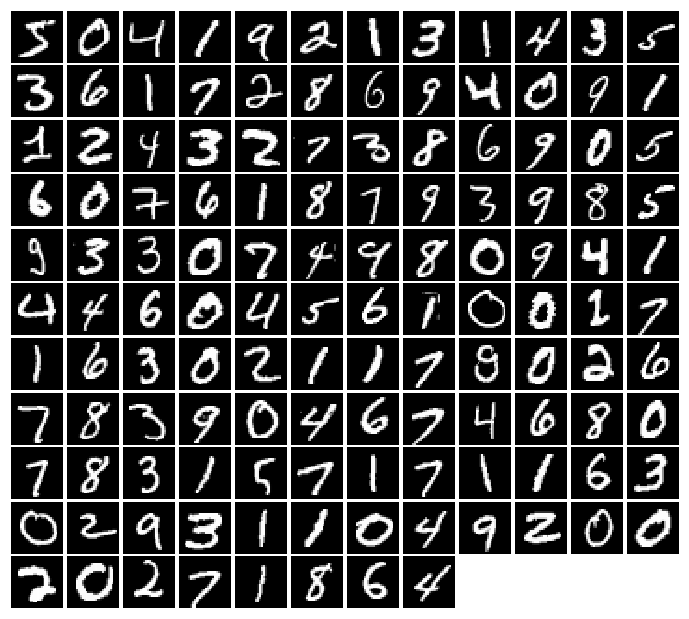

In [2]:
# 继承基类torch.utils.data.Sampler的ChunkSampler类
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

# 下载训练数据集
mnist_train = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
# 训练数据集batch划分（前50000个作为训练）
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

# 下载验证数据集
mnist_val = dset.MNIST('./cs231n/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
# 验证数据集batch划分（50001～55000作为验证）
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
Generate uniform noise from -1 to 1 with shape `[batch_size, dim]`.

Hint: use `torch.rand`.

In [3]:
def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    #pass
    
    result = torch.rand(batch_size, dim) + torch.rand(batch_size, dim) * (-1)
    
    return result
    


Make sure noise is the correct shape and type:

In [4]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


## Flatten 平铺函数和反平铺函数，用于对图像中数据的处理

Recall our Flatten operation from previous notebooks... this time we also provide an Unflatten, which you might want to use when implementing the convolutional generator. We also provide a weight initializer (and call it for you) that uses Xavier initialization instead of PyTorch's uniform default.

回想一下以前笔记本电脑的Flatten操作......这次我们还提供了一个Unflatten，你可能想在实现卷积生成器时使用它。 我们还提供了一个权重初始化器（并为您调用），它使用Xavier初始化而不是PyTorch的统一默认值。

In [5]:
# 网络中某一层图像数据的平铺
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# 网络中图像数据的反平铺    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

# 对模型中某一层的参数初始化    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

## CPU / GPU
By default all code will run on CPU. GPUs are not needed for this assignment, but will help you to train your models faster. If you do want to run the code on a GPU, then change the `dtype` variable in the following cell.

In [6]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
Our first step is to build a discriminator. Fill in the architecture as part of the `nn.Sequential` constructor in the function below. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.

我们使用LeakyRelu，设定其alpha参数为0.01
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

鉴别器的输出应该具有形状[batch_size，1]，并且包含对应于每个batch_size输入是真实图像的分数的实数。

In [7]:
def discriminator():
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, 1)
    )
    return model

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

In [9]:
def generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the architecture above.
    """
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 784),
        nn.Tanh(),
    )
    return model

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

上面的式子相较于原始的式子都取反了，所以目标就变成了最小化loss

**HINTS**: You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

提示：您应该使用下面定义的bce_loss函数来计算二进制交叉熵损失，该二元交叉熵损失是在鉴别器输出的logits输出的情况下计算真实标签的对数概率所需的。 给定得分s∈ℝ和标签y∈{0,1}，也就是输出相对于正确分类的损失，二元交叉熵损失为

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

A naive implementation of this formula can be numerically unstable, so we have provided a numerically stable implementation for you below.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

您还需要计算与real或fake对应的标签，并使用logit参数来确定其大小。 确保使用全局dtype变量将这些标签转换为正确的数据类型，例如：


`true_labels = torch.ones(size).type(dtype)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

而不是计算logD（G（z）），logD（x）和log（1-D（G（z）））的期望，我们将对小批量的元素进行平均，所以确保将损失结合起来 平均而不是求和。

In [11]:
def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.
    根据分数（0～1之间的分数）和标签（0，1）计算交叉熵损失（其实默认的就是分数越接近1越认为是标签1，分数越接近0越认为是标签0，0.5为分界线）

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    返回minibatch的平均loss
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

In [12]:
def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    loss = None
    
    # Batch size
    N = logits_real.size()
    
    # 目标标签（是否是真实图像 真：1，假：0）,封装成Variable是为了能构成计算图参与反向传播
    true_label = Variable(torch.ones(N)).type(dtype)
    real_image_loss = bce_loss(logits_real, true_label) # 真实图像鉴别与真实图像label的交叉熵损失
    fake_image_loss = bce_loss(logits_fake, 1-true_label) # 生成图像鉴别与生成图像label的交叉熵损失
        
    loss = real_image_loss + fake_image_loss
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss described above.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    loss = None
    
    # Batch size
    N = logits_fake.size()
    
    # 目标标签
    true_label = Variable(torch.ones(N)).type(dtype)
    
    # 生成器的目的是为了欺骗鉴别器，所以要求生成器部分的损失越小，那么就意味着将假图像分类成真实图像的交叉熵损失越小
    loss = bce_loss(logits_fake, true_label)
    
    return loss

Test your generator and discriminator loss. You should see errors < 1e-7.

In [14]:
from torch.autograd import Variable

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


In [15]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
Make a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. You'll use this to construct optimizers for the generators and discriminators for the rest of the notebook.

In [16]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = None
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    
    return optimizer

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [45]:
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator 鉴别器模型和生成器模型
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator. 鉴别器模型和生成器模型的各自的优化器（梯度更新方法）
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively. 鉴别器和生成器的loss计算
    - show_every: Show samples after every show_every iterations. 迭代多少次显示训练信息（阈值）
    - batch_size: Batch size to use for training. batch大小
    - noise_size: Dimension of the noise to use as input to the generator. 初始化噪声的维度（每一幅噪声图D）
    - num_epochs: Number of epochs over the training dataset to use for training. 训练整体总群数
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            
            # 鉴别器的优化器梯度置零
            D_solver.zero_grad()
            # 统一输入数据的数据类型
            real_data = x.type(dtype)
            # 真实图像经过鉴别器，输出判定分数
            logits_real = D(2* (real_data - 0.5)).type(dtype)

            # 假图初始化（由01之间的噪声产生）
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            # 假图通过生成模型产生和训练集相似分布的假图
            fake_images = G(g_fake_seed).detach()
            # 生成的假图经过鉴别器，输出判定分数
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            # 计算GAN的鉴别器部分的loss
            d_total_error = discriminator_loss(logits_real, logits_fake)
            # 反向传播
            d_total_error.backward()
            # 更新鉴别器模型参数
            D_solver.step()

            # 生成器梯度置零
            G_solver.zero_grad()
            # 假图初始化
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            # 假图通过生成模型产生和训练集相似分布的假图
            fake_images = G(g_fake_seed)

            # 生成的假图经过鉴别器，输出判定分数
            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            # 生成器部分的loss
            g_error = generator_loss(gen_logits_fake)
            # 反向传播
            g_error.backward()
            # 生成器模型参数更新
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

Iter: 0, D: 1.33, G:0.7142


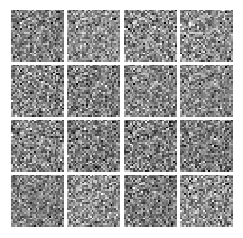


Iter: 250, D: 1.435, G:0.7617


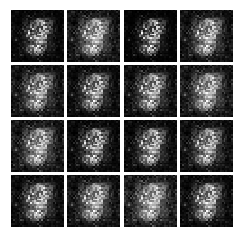


Iter: 500, D: 0.8593, G:2.02


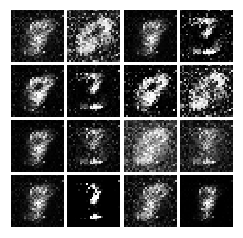


Iter: 750, D: 1.195, G:0.992


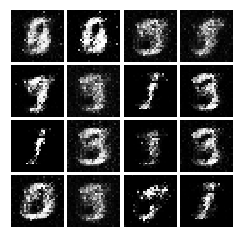


Iter: 1000, D: 1.148, G:1.065


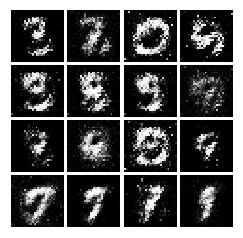


Iter: 1250, D: 1.088, G:1.29


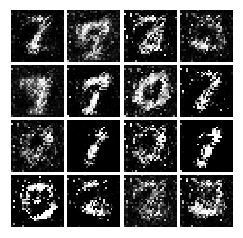


Iter: 1500, D: 1.286, G:0.8584


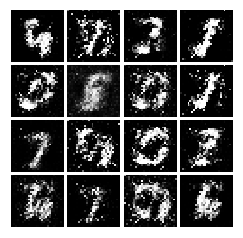


Iter: 1750, D: 1.297, G:0.8492


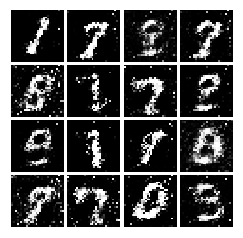


Iter: 2000, D: 1.354, G:1.025


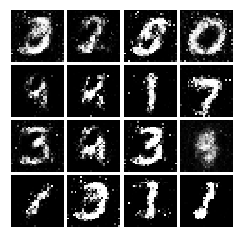


Iter: 2250, D: 1.249, G:0.9594


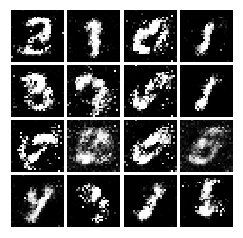


Iter: 2500, D: 1.434, G:0.8797


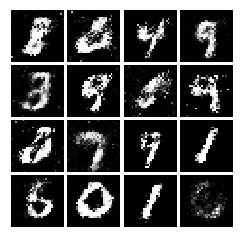


Iter: 2750, D: 1.241, G:0.9266


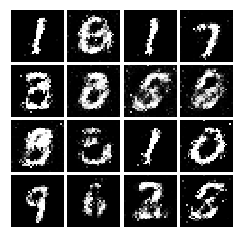


Iter: 3000, D: 1.263, G:0.8144


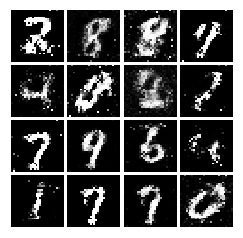


Iter: 3250, D: 1.417, G:0.833


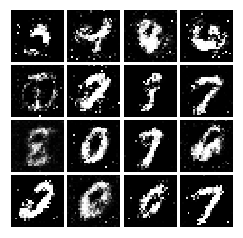


Iter: 3500, D: 1.289, G:0.8076


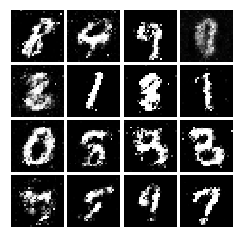


Iter: 3750, D: 1.298, G:0.7184


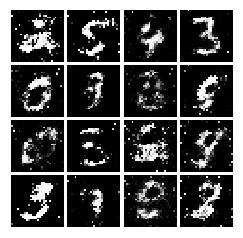


Iter: 4000, D: 1.29, G:0.7687


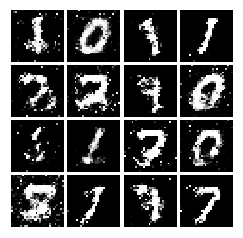


Iter: 4250, D: 1.288, G:1.043


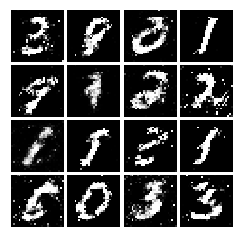


Iter: 4500, D: 1.278, G:0.8619


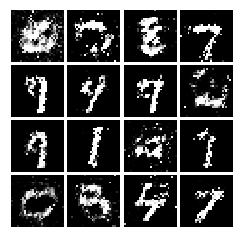


Iter: 4750, D: 1.33, G:0.7613


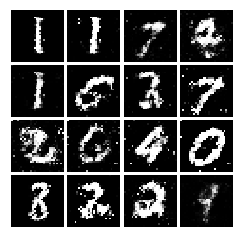


Iter: 5000, D: 1.395, G:0.9441


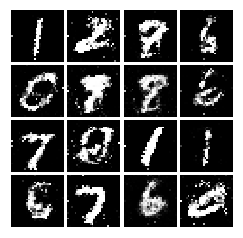


Iter: 5250, D: 1.384, G:0.7725


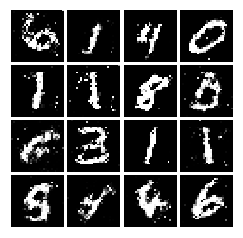


Iter: 5500, D: 1.36, G:0.7159


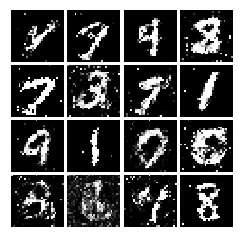


Iter: 5750, D: 1.312, G:0.7577


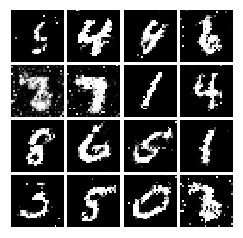


Iter: 6000, D: 1.367, G:0.8083


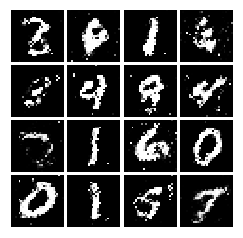


Iter: 6250, D: 1.389, G:0.8758


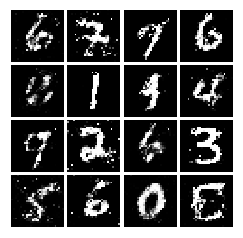


Iter: 6500, D: 1.315, G:0.7431


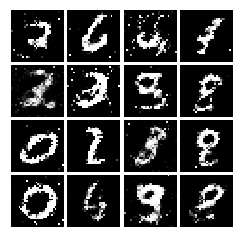


Iter: 6750, D: 1.303, G:0.8403


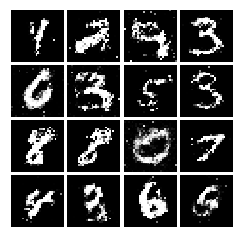


Iter: 7000, D: 1.363, G:0.7429


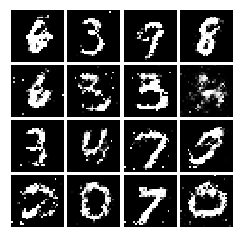


Iter: 7250, D: 1.357, G:0.746


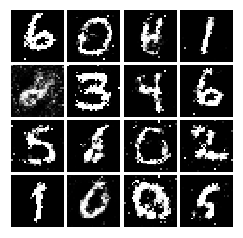


Iter: 7500, D: 1.322, G:0.7234


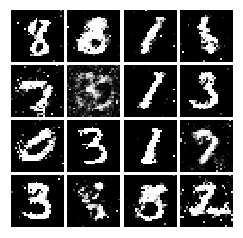


Iter: 7750, D: 1.338, G:0.737


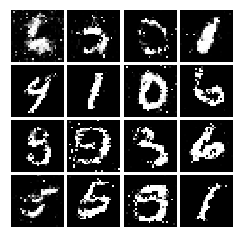

In [20]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss)

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

那不是那么难，是吗？ 在低100s的迭代中，您应该看到黑色背景，接近迭代1000时的模糊形状，以及不错的形状，当我们通过3000时，其中大约一半将是清晰且清晰可辨的。

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [27]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    
    N = scores_real.size()
    
    true_labels = Variable(torch.ones(N)).type(dtype)
    
    real_img_loss = (torch.mean((scores_real - true_labels)**2))
    fake_img_loss = (torch.mean((scores_fake)**2))
    
    loss = 0.5 * (real_img_loss + fake_img_loss)
    
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    loss = None
    
    N = scores_fake.size()
    
    true_labels = Variable(torch.ones(N)).type(dtype)
    loss = 0.5 * (torch.mean((scores_fake - true_labels)**2))
    
    return loss

Before running a GAN with our new loss function, let's check it:

In [28]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


Run the following cell to train your model!

Iter: 0, D: 0.4533, G:0.4541


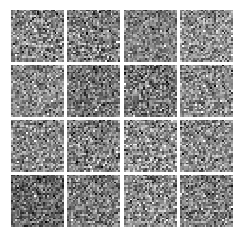


Iter: 250, D: 0.2585, G:0.2072


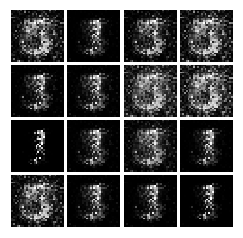


Iter: 500, D: 0.09656, G:0.551


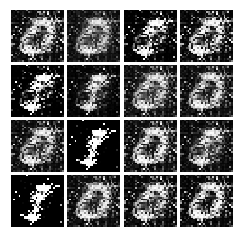


Iter: 750, D: 0.1764, G:0.3162


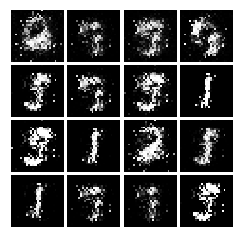


Iter: 1000, D: 0.1733, G:0.2756


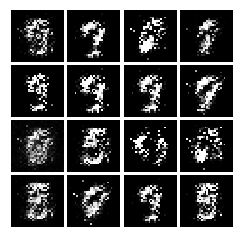


Iter: 1250, D: 0.1341, G:0.3719


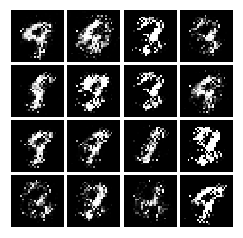


Iter: 1500, D: 0.1744, G:0.1527


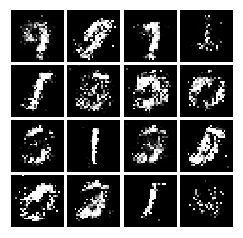


Iter: 1750, D: 0.2205, G:0.299


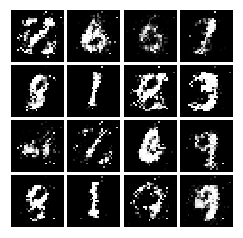


Iter: 2000, D: 0.2227, G:0.2106


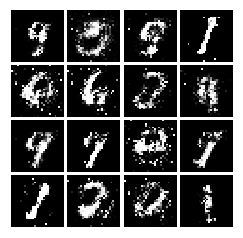


Iter: 2250, D: 0.2215, G:0.1634


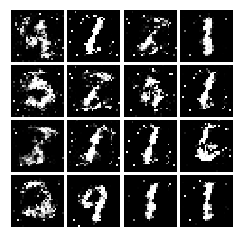


Iter: 2500, D: 0.2069, G:0.2263


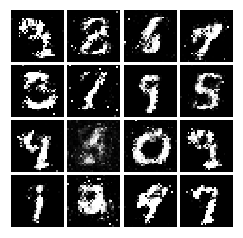


Iter: 2750, D: 0.209, G:0.1747


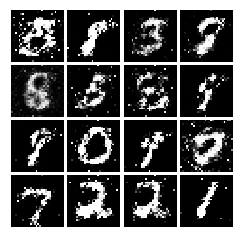


Iter: 3000, D: 0.2185, G:0.1735


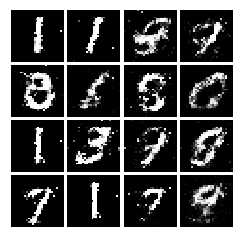


Iter: 3250, D: 0.2247, G:0.1883


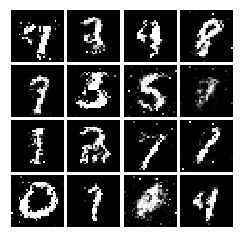


Iter: 3500, D: 0.2195, G:0.1618


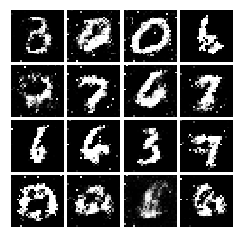


Iter: 3750, D: 0.2232, G:0.1651


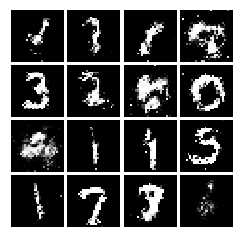


Iter: 4000, D: 0.2352, G:0.1725


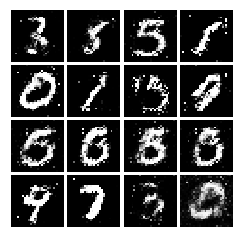


Iter: 4250, D: 0.2136, G:0.1631


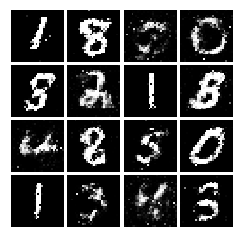


Iter: 4500, D: 0.262, G:0.1696


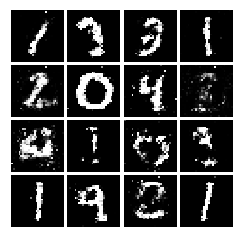


Iter: 4750, D: 0.2518, G:0.1827


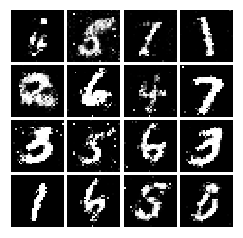


Iter: 5000, D: 0.2372, G:0.1506


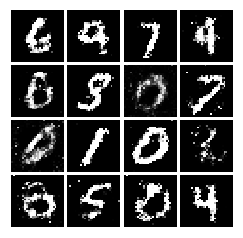


Iter: 5250, D: 0.248, G:0.14


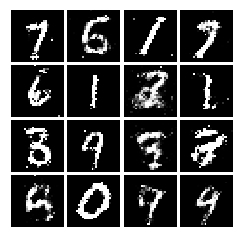


Iter: 5500, D: 0.2385, G:0.1525


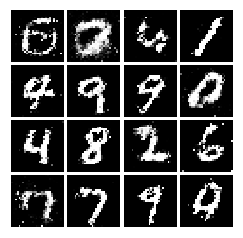


Iter: 5750, D: 0.2334, G:0.1683


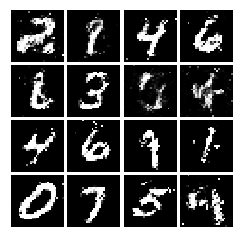


Iter: 6000, D: 0.2415, G:0.1542


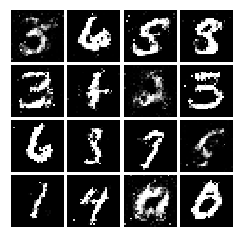


Iter: 6250, D: 0.2337, G:0.168


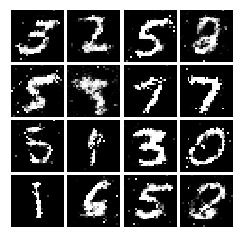


Iter: 6500, D: 0.2283, G:0.2468


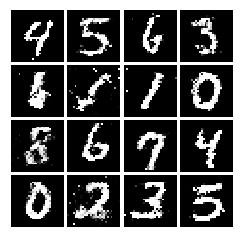


Iter: 6750, D: 0.2302, G:0.1632


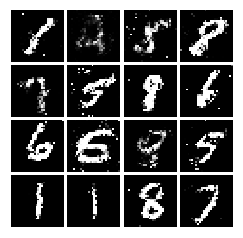


Iter: 7000, D: 0.2491, G:0.1693


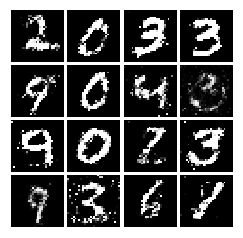


Iter: 7250, D: 0.2415, G:0.1291


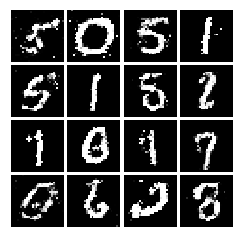


Iter: 7500, D: 0.2317, G:0.1539


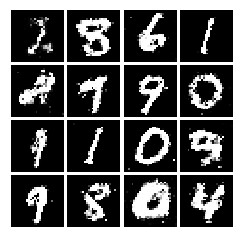


Iter: 7750, D: 0.2215, G:0.1434


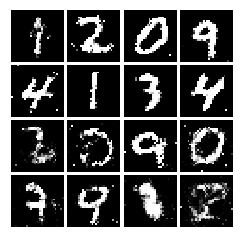

In [29]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss)

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks 

在笔记本的第一部分，我们实现了Ian Goodfellow的原始GAN网络的几乎直接副本。 但是，这种网络架构不允许真正的空间推理。 一般来说，它无法推断像“尖锐边缘”这样的东西，因为它没有任何卷积层。 因此，在本节中，我们将实现DCGAN的一些想法，我们使用卷积网络

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly. 
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

In [34]:
def build_dc_classifier():
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ###########################
        Unflatten(batch_size, 1, 28, 28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(negative_slope=0.01),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(4*4*64, 4*4*64),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Linear(4*4*64, 1),
    )

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier().type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [35]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode. 

对于生成器，我们将完全从InfoGAN文件中复制该体系结构。 见附录C.1 MNIST。 请参阅tf.nn.conv2d_transpose的文档。 我们总是在GAN模式中“训练”。

* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

In [43]:
def build_dc_generator(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model implementing the DCGAN generator using
    the architecture described above.
    """
    return nn.Sequential(
        ###########################
        ######### TO DO ###########
        ########################### 
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features=1024),
        nn.Linear(1024, 7*7*128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features=7*7*128),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features=64),
        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten(),
    )

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

#fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_seed = Variable(torch.randn(batch_size, NOISE_DIM)).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

Check the number of parameters in your generator as a sanity check:

In [44]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


Iter: 0, D: 1.489, G:0.2014


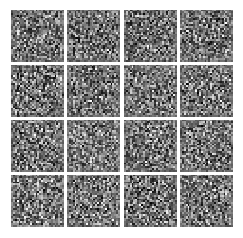


Iter: 250, D: 1.576, G:1.501


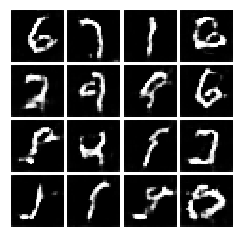


Iter: 500, D: 1.225, G:0.805


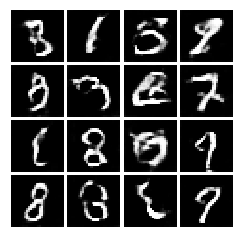


Iter: 750, D: 1.26, G:0.8897


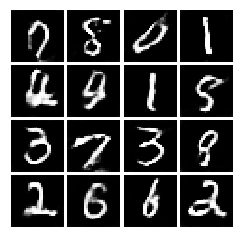


Iter: 1000, D: 1.212, G:0.8548


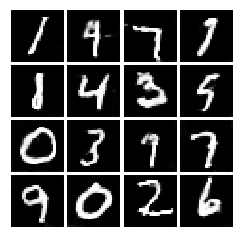


Iter: 1250, D: 1.331, G:0.8911


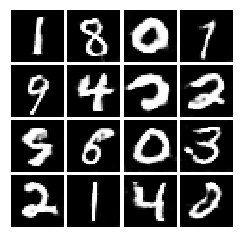


Iter: 1500, D: 1.225, G:0.8641


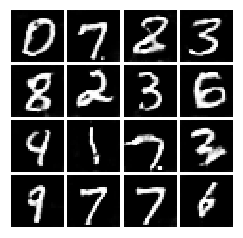


Iter: 1750, D: 1.151, G:0.8468


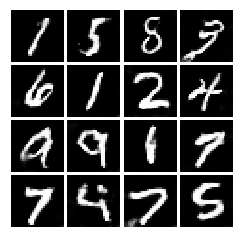

In [46]:
D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, num_epochs=5)

Iter: 0, D: 0.432, G:1.545


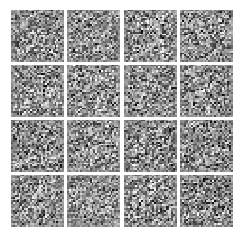


Iter: 250, D: 0.2452, G:0.2434


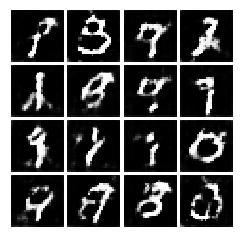


Iter: 500, D: 0.2096, G:0.1548


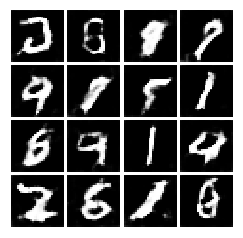


Iter: 750, D: 0.2097, G:0.2013


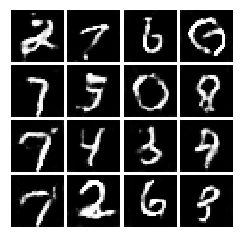


Iter: 1000, D: 0.2484, G:0.162


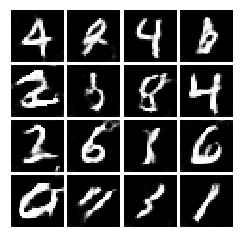


Iter: 1250, D: 0.2443, G:0.1754


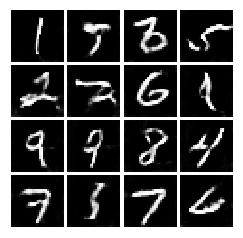


Iter: 1500, D: 0.21, G:0.1923


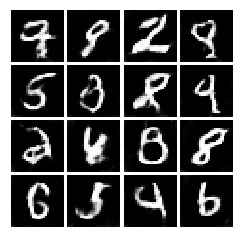


Iter: 1750, D: 0.2071, G:0.1589


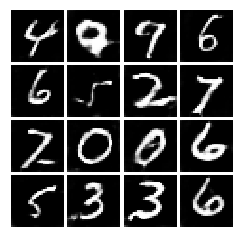

In [47]:
# 尝试一下 LS+DCGAN

D_DC = build_dc_classifier().type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, ls_discriminator_loss, ls_generator_loss, num_epochs=5)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x) with step size $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

我们将看一个例子，看看为什么交替最小化同一目标（如在GAN中）可能是棘手的业务。

考虑f（x，y）= xy。 minxmaxyf（x，y）评估的是什么？ （提示：minmax尝试最小化可实现的最大值。）

现在尝试通过使用步长为1的交替梯度（首先更新y，然后更新x），以数字方式评估此函数6个步骤，从点（1,1）开始。 你会发现用xt，yt，xt + 1，yt + 1来写出更新步骤会很有用。

在下表中记录（xt，yt）的六对显式值。

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |   2   |   3   |   4   |   5   |   6   |    7   
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |   0   |   -1   |   -2   |  -3    |   -4   |   -5   
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

结果显示不能，交叉影响最终的大小

### Your answer:

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient

### Your answer:
不好，鉴别器的损失很高说明鉴别器的性能不行，那么判定生成器的好坏就没有意义！